In [3]:
def rlr_validate(X, y, lambdas, cvf=10):
    """Validate regularized linear regression model using 'cvf'-fold cross validation.
    Find the optimal lambda (minimizing validation error) from 'lambdas' list.
    The loss function computed as mean squared error on validation set (MSE).
    Function returns: MSE averaged over 'cvf' folds, optimal value of lambda,
    average weight values for all lambdas, MSE train&validation errors for all lambdas.
    The cross validation splits are standardized based on the mean and standard
    deviation of the training set when estimating the regularization strength.

    Parameters:
    X       training data set
    y       vector of values
    lambdas vector of lambda values to be validated
    cvf     number of crossvalidation folds

    Returns:
    opt_val_err         validation error for optimum lambda
    opt_lambda          value of optimal lambda
    mean_w_vs_lambda    weights as function of lambda (matrix)
    train_err_vs_lambda train error as function of lambda (vector)
    test_err_vs_lambda  test error as function of lambda (vector)
    """
    CV = model_selection.KFold(cvf, shuffle=True)
    M = X.shape[1]
    w = np.empty((M, cvf, len(lambdas)))
    train_error = np.empty((cvf, len(lambdas)))
    test_error = np.empty((cvf, len(lambdas)))
    f = 0
    y = y.squeeze()
    for train_index, test_index in CV.split(X, y):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]

        # Standardize the training and set set based on training set moments
        mu = np.mean(X_train[:, 1:], 0)
        sigma = np.std(X_train[:, 1:], 0)

        X_train[:, 1:] = (X_train[:, 1:] - mu) / sigma
        X_test[:, 1:] = (X_test[:, 1:] - mu) / sigma

        # precompute terms
        Xty = X_train.T @ y_train
        XtX = X_train.T @ X_train
        for l in range(0, len(lambdas)):
            # Compute parameters for current value of lambda and current CV fold
            # note: "linalg.lstsq(a,b)" is substitue for Matlab's left division operator "\"
            lambdaI = lambdas[l] * np.eye(M)
            lambdaI[0, 0] = 0  # remove bias regularization
            w[:, f, l] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
            # Evaluate training and test performance
            train_error[f, l] = np.power(y_train - X_train @ w[:, f, l].T, 2).mean(
                axis=0
            )
            test_error[f, l] = np.power(y_test - X_test @ w[:, f, l].T, 2).mean(axis=0)

        f = f + 1

    opt_val_err = np.min(np.mean(test_error, axis=0))
    opt_lambda = lambdas[np.argmin(np.mean(test_error, axis=0))]
    train_err_vs_lambda = np.mean(train_error, axis=0)
    test_err_vs_lambda = np.mean(test_error, axis=0)
    mean_w_vs_lambda = np.squeeze(np.mean(w, axis=1))

    return (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    )

In [5]:
# exercise 8.1.1

from matplotlib.pylab import (
    figure,
    semilogx,
    loglog,
    xlabel,
    ylabel,
    legend,
    title,
    subplot,
    show,
    grid,
)
import numpy as np
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [ ]:
mat_data = loadmat("../Data/body.mat")
X = mat_data["X"]
y = mat_data["y"].squeeze()
attributeNames = [name[0] for name in mat_data["attributeNames"][0]]
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = ["Offset"] + attributeNames
M = M + 1

In [48]:
%store -r data

X = data.drop("Gross", axis=1)  # Features (indipendent variables)
X = X.drop(columns="title")
y = data["Gross"]  # Target variable (dipendent variable)
# X["bias"] = 1
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to your feature matrix and transform it
X = scaler.fit_transform(X)

N, M = X.shape

In [49]:
attributeNames = data.keys()

In [50]:
attributeNames = [
    "MPAA_Rating",
    "genre",
    "Budget",
    "Gross",
    "release_date",
    "runtime",
    "rating",
    "rating_count",
]

In [51]:
X

array([[-1.10169637, -0.44733049, -1.28556704, ..., -0.89431862,
         0.51229725, -0.81883101],
       [-1.10169637, -0.23646537, -1.20412211, ..., -0.84960269,
         0.28248853, -0.81772249],
       [ 1.39256014,  2.08305103, -1.18931394, ...,  1.16261421,
         0.28248853, -0.81772249],
       ...,
       [ 0.14543189, -1.07992587,  0.23227025, ...,  1.69920538,
        -1.09636385, -0.52836567],
       [ 0.14543189, -0.44733049, -1.14488943, ..., -0.31301152,
        -2.93483368, -1.1148683 ],
       [ 0.14543189, -0.44733049, -1.10046493, ..., -0.62602304,
        -2.81992931, -1.11497915]])

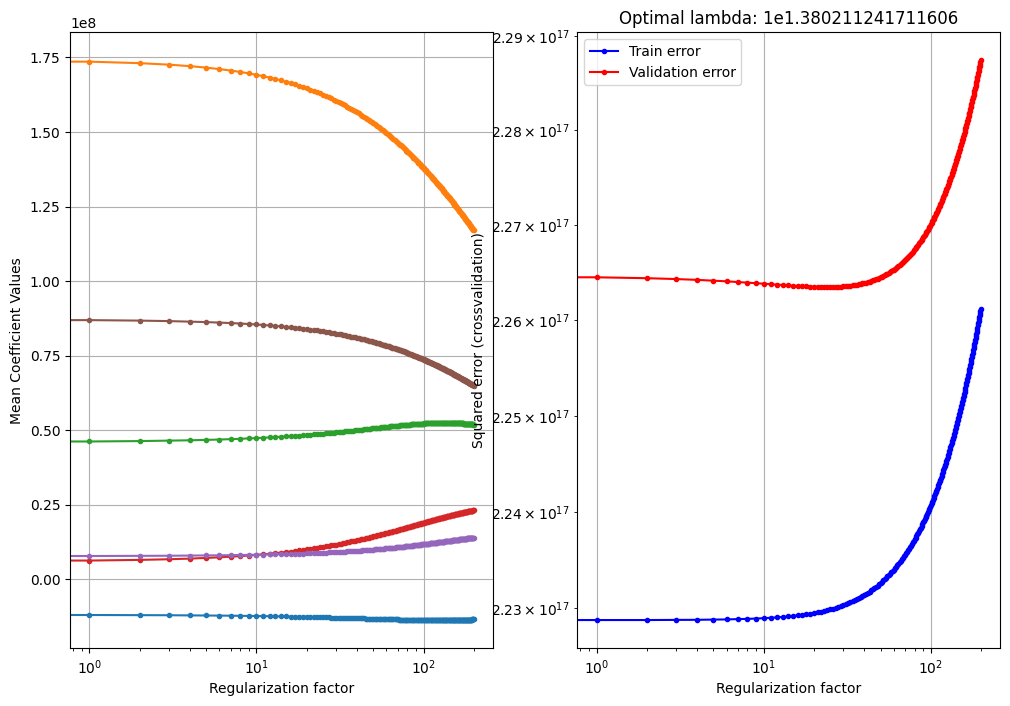

In [54]:
# Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(K, shuffle=True)
# CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.arange(0, 200, 1, dtype="float")

# Initialize variables
# T = len(lambdas)
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))
w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y.to_numpy()[train_index]
    X_test = X[test_index]
    y_test = y.to_numpy()[test_index]
    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)
    # for lambda_i in lambdas:
    #     y_pred = cross_val_predict(
    #         Ridge(alpha=lambda_i), X_train, y_train, cv=internal_cross_validation
    #     )

    # # Standardize outer fold based on training set, and save the mean and standard
    # # deviations since they're part of the model (they would be needed for
    # # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()

    # # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    m = lm.LinearRegression().fit(X_train, y_train)
    Error_train[k] = np.square(y_train - m.predict(X_train)).sum() / y_train.shape[0]
    Error_test[k] = np.square(y_test - m.predict(X_test)).sum() / y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K - 1:
        figure(k, figsize=(12, 8))
        subplot(1, 2, 1)
        # Don't plot the bias term
        semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")
        xlabel("Regularization factor")
        ylabel("Mean Coefficient Values")
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner
        # plot, since there are many attributes
        # legend(attributeNames[1:], loc='best')

        subplot(1, 2, 2)
        title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        xlabel("Regularization factor")
        ylabel("Squared error (crossvalidation)")
        legend(["Train error", "Validation error"])
        grid()

    # To inspect the used indices, use these print statements
    # print('Cross validation fold {0}/{1}:'.format(k+1, K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}\n'.format(test_index))

    k += 1

show()

In [55]:
print("Regularized linear regression:")
print("- Training error: {0}".format(Error_train_rlr.mean()))
print("- Test error:     {0}".format(Error_test_rlr.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train_rlr.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test_rlr.sum())
        / Error_test_nofeatures.sum()
    )
)

print("Weights in last fold:")
for m in range(M):
    print("{:>15} {:>15}".format(attributeNames[m], np.round(w_rlr[m, -1], 2)))

print("Ran Exercise 8.1.1")

Regularized linear regression:
- Training error: 2.3726718102215763e+17
- Test error:     2.4101910796888218e+17
- R^2 train:     -1.0819676030397178
- R^2 test:     -1.1369838239499235

Weights in last fold:
    MPAA_Rating      -581748.97
          genre    -12687105.85
         Budget    163893026.69
          Gross     48699595.68
   release_date     10493650.86
        runtime      8753428.54
         rating     83529301.79
Ran Exercise 8.1.1
